In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd

In [2]:
data_table_path = "../../data/pocovid_data.csv"
data_path = "/Users/ninawiedemann/Desktop/COVID Clinical Gallery Butterfly Network/" # os.path.join("", ) # TODO: download into data directory
FRAMERATE = 3 # saves automatically 3 frames per second
MAX_FRAMES = 30
OUT_DIR = "../../data/butterfly/images"
del_upper = 100

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('-data', type=str, default="butterfly")
parser.add_argument('-out', type=str, default="out_images") # TODO
parser.add_argument('-fr', help="framerate - at how much Hz to sample", type=int, default=3)
parser.add_argument('-max', help="maximum of frames to sample from one video", type=int, default=30)
args = parser.parse_args()

In [3]:
def get_paths(data_table_path):
    data_table = pd.read_csv(data_table_path)
    butterfly = data_table["Filename"].values
    butterfly = [b for b in butterfly if "utterfly" in b]
    actual_names = [b.split("Butterfly-")[-1] for b in butterfly]
    labels = [b[:3] for b in butterfly]
    return actual_names, labels

In [5]:
def get_processing_info(data_path,  actual_names, labels):
    """
    Iterates over the downloaded data and checks which one is in our database
    Returns:
        files_to_process: List of file paths to videos
        labs_to_process: list of same length with corresponding labels
    """
    files_to_process = []
    labs_to_process = []
    for img_type in os.listdir(data_path):
        if img_type[0]==".":
            continue
        # img_type is B-lines, cardiac etc
        for vid in os.listdir(os.path.join(data_path, img_type)):
            # print(vid)
            if vid in actual_names:
                full_path = os.path.join(data_path, img_type, vid)
                files_to_process.append(full_path)
                ind = actual_names.index(vid)
                labs_to_process.append(labels[ind])
    return files_to_process, labs_to_process

def makedirs(out_dir):
    for mod in ["covid", "pneumonia", "regular"]:
        if not os.path.exists(os.path.join(out_dir, mod)):
            os.makedirs(os.path.join(out_dir, mod))
        
def label_to_dir(lab):
    if lab=="Cov":
        label = "covid"
    elif lab=="Pne" or lab=="pne":
        label = "pneumonia"
    elif lab=="Reg":
        label = "regular"
    else:
        raise ValueError("Wrong label! "+ vid_files[i])
    return label

## Run

In [7]:
actual_names, labels = get_paths(data_table_path)
# manually add the ones which I know are in the data
actual_names.extend(["Confluent B lines.mp4", "Skip Lesion.mp4"])
labels.extend(["Cov", "Cov"])
files_to_process, labs_to_process = get_processing_info(data_path,  actual_names, labels)
makedirs(OUT_DIR)

In [13]:
# read and write if frame is selected
for i in range(len(files_to_process)): # 1,2): # 
    fp = files_to_process[i]
    fn = fp.split(os.sep)[-1]
    cap = cv2.VideoCapture(fp)   # capturing the video from the given path
    # frame rate
    n_frames = cap.get(7)
    frameRate = cap.get(5)
    every_x_image = int(frameRate/FRAMERATE)
    out_path = os.path.join(OUT_DIR, label_to_dir(labs_to_process[i]))
    print("PROCESS", fn, labs_to_process[i], "framerate", int(cap.get(5)),"width", cap.get(3), "height", cap.get(4), "number frames:", cap.get(7))
    
    nr_selected = 0
    while cap.isOpened() and nr_selected<MAX_FRAMES:
        frameId = cap.get(1) # current frame number
        ret, frame = cap.read()
        if (ret != True):
            break        
        
        frame = np.asarray(frame).astype(int)
        # width_box = np.min(frame.shape[:2])
        # crop
        width_border =  int(cap.get(3) * 0.15)
        width_box =  int(cap.get(3)) - 2*width_border
        frame = frame[del_upper:width_box+del_upper, width_border:width_box+width_border]
        # frame = frame[width_border:width_box+width_border]
        # detect green point
        green_point = frame[:,:,1] - frame[:,:,0]
        # delete blue symbol
        blue_symbol = np.where(green_point<-50)
        frame[blue_symbol] = frame[0,0]
        # delete green symbol
        if np.any(green_point>235):
            green_symbol = np.where(green_point>50)
            frame[green_symbol] = frame[0,0]
        # leave out moving green points
        elif np.any(green_point>100):
            continue
        
        # SAVE
        if (frameId % every_x_image == 0):
            # storing the frames in a new folder named test_1
            filename = os.path.join(out_path, fn +"_frame%d.jpg" % frameId)
            cv2.imwrite(filename, frame)
            nr_selected += 1
    print("Selected", nr_selected, "frames")
    cap.release()

PROCESS Patchy B lines with Sparing.mp4 Cov framerate 21 width 880.0 height 1080.0 number frames: 109.0
Selected 16 frames
PROCESS Confluent B lines_Example 2.mp4 Cov framerate 19 width 1928.0 height 1080.0 number frames: 91.0
Selected 15 frames
PROCESS Confluent B lines.mp4 Cov framerate 30 width 720.0 height 1236.0 number frames: 818.0
Selected 16 frames
PROCESS Coalescing B lines.mp4 Cov framerate 19 width 880.0 height 1080.0 number frames: 65.0
Selected 11 frames
PROCESS Skip Lesion.mp4 Cov framerate 30 width 720.0 height 1236.0 number frames: 1306.0
Selected 30 frames
PROCESS Consolidation_Example 5.mp4 Cov framerate 20 width 624.0 height 1080.0 number frames: 114.0
Selected 19 frames
PROCESS Consolidation_Example 3.mp4 Cov framerate 19 width 1928.0 height 1080.0 number frames: 80.0
Selected 14 frames
PROCESS Consolidation_Example 2.mp4 Cov framerate 21 width 880.0 height 1080.0 number frames: 109.0
Selected 16 frames
PROCESS Consolidation.mp4 Cov framerate 19 width 880.0 height 1

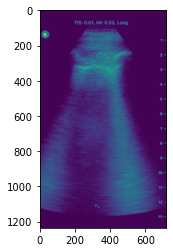

In [42]:
red_col = frame[:,:,0] - 0.5*(frame[:,:,1] - frame[:,:,2]) # get only the point in the corner
green_point = frame[:,:,1] - 0.5*(frame[:,:,0] - frame[:,:,2])
plt.imshow(green_point)
plt.show()

# NOTES

COVID Lung 1 = Confluent B lines in folder

In our data but not in the zip:
'COVID Skip Lesion.mp4',
 'COVID Lung 1.mp4',
 'COVID Lung 2.mp4',
 'Butterfly.mp4',
 '2.mp4',

In [65]:
butterfly

['Cov-Butterfly-COVID Skip Lesion.mp4',
 'Cov-Butterfly-COVID Lung 1.mp4',
 'Cov-Butterfly-COVID Lung 2.mp4',
 'Reg-Butterfly.mp4',
 'Reg-Butterfly-2.mp4',
 'Cov-Butterfly-Coalescing B lines.mp4',
 'Cov-Butterfly-Confluent B lines_Example 2.mp4',
 'Cov-Butterfly-Consolidation with Air Bronchograms.mp4',
 'Cov-Butterfly-Consolidation.mp4',
 'Cov-Butterfly-Consolidation_Example 2.mp4',
 'Cov-Butterfly-Consolidation_Example 3.mp4',
 'Cov-Butterfly-Consolidation_Example 5.mp4',
 'Cov-Butterfly-Irregular Pleura and Coalescent B-lines.mp4',
 'Cov-Butterfly-Irregular Pleura with Confluent B-lines.mp4',
 'Cov-Butterfly-Irregular Pleura with Multiple B lines.mp4',
 'Cov-Butterfly-Irregular Pleura with Trace Effusion.mp4',
 'Cov-Butterfly-Irregular Pleural Line.mp4',
 'Cov-Butterfly-Irregular Pleural Line_Example 2.mp4',
 'Cov-Butterfly-Patchy B lines with Sparing.mp4',
 'Cov-Butterfly-Subpleural Basal Consolidation.mp4',
 'Cov-Butterfly-Subpleural Basal Consolidation_Example 2.mp4']